<a target="_blank" href="https://colab.research.google.com/github/ArtificialIntelligenceToolkit/aitk/blob/master/notebooks/Advanced/MazeSearch.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applying Novelty Search to a Robot Maze Task

In this notebook we will try to reproduce the maze task in Lehman and Stanley's paper *Abandoning Objectives: Evolution through the Search for Novelty Alone* [1].  

In this maze task, there is a beacon that the robot is trying to reach.  The signal from the beacon is not blocked by walls. The robot is equipped with a compass sensor that indicates one of four possible directions where the beacon is located relative to the robot. The robot is also equipped with range sensors that allow it to sense obstacles.

This is a hard task because if the robot tries to go directly towards the beacon it will be blocked by a wall. It must learn to actually traverse the maze to enable it to reach the beacon.

The question is can we evolve a neural network controller that allows the robot to navigate to the beacon without actually giving it that objective. Instead we will focus on evolving neural network controllers that get the robot to novel locations in its world using a technique called *novelty search*.

In [1]:
%pip install aitk --quiet

In [2]:
from aitk.robots import World, Scribbler, Beacon, Compass, RangeSensor

## Create the world

We begin by creating a world with a number of walls that will require the robot to navigate through several passsage ways to reach the beacon. The beacon is represented by a blue circle in the top-left corner of the world. We are starting with a much simpler world than the one used in the original paper.

In [3]:
world = World(200,200)
world.add_wall("black",0,50,125,55)
world.add_wall("black",65,50,70,150)
world.add_wall("black",65,150,125,155)
world.add_wall("black",125,100,200,105)
world.add_beacon(25, 25, 0)
world.watch()

Random seed set to: 9384067


Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

## Create the robot

The robot will be able to sense the direction of the beacon within four quadrants. It will also be equipped with five range sensors concentrated around its front half, and one on its backend.

In [4]:
robot = Scribbler(25, 175, 89)
robot.add_device(Compass())
robot.add_device_ring(RangeSensor,8,-90,90,5,max=40,width=0)
robot.add_device(RangeSensor(position=(-8,0),a=180,max=40,width=0))

In [5]:
world.add_robot(robot)

## Define the Novelty Search and the Genetic Algorithm

We will use a Genetic Algorithm to evolve a neural network controller for the robot.  To evaluate the fitness of each network we will allow it to control the robot for a fixed amount of time, and then record its ending point in the world

We will use Novelty Search to assign each ending point a score.  Ending points that are close in distance to previously seen ending points will be given low scores, while ending points that reach new territory in the world will be given higher scores. Thus novelty is rewarded.


In [6]:
from aitk.algorithms import GeneticAlgorithm, NoveltySearch
from aitk.networks import SimpleNetwork
from aitk.robots.utils import distance
import random

We will create a new class called NoveltyGA that inherits from the class GeneticAlgorithm. As is typical with machine learning, there are a number of hyperparameters that we must set that will affect the outcome the experiment.

For Novelty Search these include:
* **k**, the number of neighbors to consider when calculating novelty
* **limit**, the maximum size of the archive
* **threshhold**, the minimum distance needed to be considered novel

For the Genetic Algorithm these include:
* **length** of the chromosome, which in our case is determined by the number of parameters in our neural network
* **popsize**, the number of individuals in the population
* **fitness**, the function that determines how well the robot performed, which depends on the number of **seconds** we allow the controller to move the robot
* **mutation rate**, the probability of mutating a weight or bias within a chromosome during generation
* **crossover rate**, the probability of crossing over two children during a generation

All of these settings can be adjusted, and may make a significant difference in the outcome.



In [7]:
class NoveltyGA(GeneticAlgorithm):
    def __init__(self, popsize, world, robot, sensors=10):
        self.novelty_search = NoveltySearch(
            k=15,
            limit=100,
            threshold=0.25,
            max_dist=distance((0,0),(200,200)),
        )
        self.show = False
        self.sensors = sensors
        self.world = world
        self.robot = robot
        self.network = self.build_model()
        # Length of a chromosome:
        length = len(self.network.get_weights(flat=True))
        super().__init__(length, popsize)
    def make_random_gene(self):
        return 2 - random.random() * 4
    def mutate_gene(self, gene):
        return gene + (0.5 - random.random())
    def fitness(self, chromosome, index=None, seconds=60, interrupt=True, real_time=False,
                show=False, show_progress=False, quiet=True):
        """During search, fitness is based on novelty"""
        self.show = show
        self.network.set_weights(chromosome)
        self.robot.set_pose(25,175,89)
        self.world.seconds(seconds, self.controller, interrupt=interrupt,
                           real_time=real_time, show=show, show_progress=show_progress,
                           quiet=quiet)
        x, y, a = self.robot.get_pose()
        score = self.novelty_search.check_archive([(x, y)],chromosome)
        return score
    def test_chromo(self, chromosome, seconds=60, real_time=False):
        """Test how close the endpoint is from the start and to the beacon"""
        self.network.set_weights(chromosome)
        self.robot.set_pose(25,175,89)
        self.world.seconds(seconds, self.controller, interrupt=True,
                           real_time=real_time, show=True, show_progress=True,
                           quiet=True)
        r_x, r_y, r_a = self.robot.get_pose()
        b_x, b_y, = self.world.beacon.get_position()
        return distance((r_x, r_y), (25, 175)), distance((r_x,r_y), (b_x, b_y))
    def build_model(self):
        """Create a network to determine move from sensors"""
        return SimpleNetwork(
            self.sensors,
            5,
            2,
            activation="sigmoid"
        )
    def controller(self, world):
        """Move the robot in the world based on network ouputs"""
        sensors = self.get_sensors()
        output = self.get_move(sensors)
        self.robot.move(output[0], output[1])
        if self.robot.stalled:
            return True
    def get_sensors(self):
        """Gather the compass and range sensors together for network input"""
        compass = robot['compass'].values
        ranges = [1-robot[i].get_reading() for i in range(1,7)]
        return compass+ranges
    def get_move(self, sensors):
        """Propagate the sensor values thru network to get move output"""
        # Propagate takes a single pattern:
        output = self.network.propagate(
            sensors, show=self.show)
        # Scale the output in [-1, 1]
        return 1 - output * 2

We now create an instance of this new NoveltyGA class, that will run evolution for 30 generations using the world and robot we defined earlier.

In [8]:
ga = NoveltyGA(30, world, robot)

Genetic algorithm
  Chromosome length: 67
  Population size: 30


Why is the chromosome length 67?

Answer: There are 10x5 weights from input to hidden, plus 5x2 weights from hidden to output, and all non-input units have a bias, so 7 of those: 50+10+7 is 67.

Let's create a random network and see how it controls the robot for 10 seconds. You can watch it in the world above. Try rerunning the next cell a couple of times.

In [9]:
chromosome = ga.make_random_chromosome()
ga.fitness(chromosome, seconds=10, real_time=False, show=True)

  0%|          | 0/100 [00:00<?, ?it/s]

1.0

##  Start the Evolutionary Process

Let's evolve for 10 generations. This will take 5-10 minutes. You can watch the progress of the generations.

In a typical GA we would expect to see the best fitness increasing fairly steadily over time. However, when using NoveltySearch to determine the fitness, the best fitness may look quite static, because early on everything is very novel, and as more end points are added to the archive it becomes more difficult to find novel outcomes. So you may still find a diverse array of end points even if the best fitness is not increasing over time.

In [10]:
%%time
bestFound = ga.evolve(
    generations=10,
    crossover_rate=0.0,
    mutation_rate=0.75,
    elite_percent=0,
    seconds=60,
    show=False,
)

Maximum number of generations: 10
  Elite percentage 0 (0/30 chromosomes per generation)
  Crossover rate: 0.0 (~0/30 crossovers per generation)
  Mutation rate: 0.75 (~3015/2010 genes per generation)
Evaluating initial population...
Done!


  0%|          | 0/10 [00:00<?, ?it/s]

Generation    1 Best fitness 0.43
Generation    2 Best fitness 0.51
Generation    3 Best fitness 0.51
Generation    4 Best fitness 0.51
Generation    5 Best fitness 0.51
Generation    6 Best fitness 0.51
Generation    7 Best fitness 0.51
Generation    8 Best fitness 0.51
Generation    9 Best fitness 0.51
Generation   10 Best fitness 0.51
Max generations reached
CPU times: user 6min 26s, sys: 1.59 s, total: 6min 28s
Wall time: 7min 5s


## Analyze the results


### Plot the archive growth

Let's look at how fast the archive grew over the course of the evolutionary process. Remember that we set the archive's limit to be 100 when we initialized novelty search above. However, the archive size may be much smaller than this limit if the evolution wasn't able to discover a wide variety of endpoints.


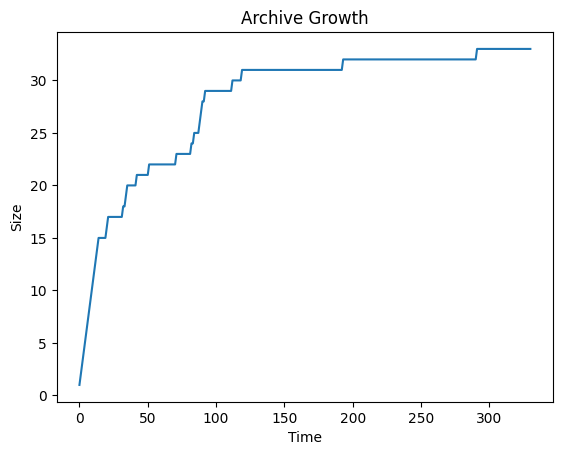

In [11]:
ga.novelty_search.plot_growth()

Each item in the archive is a data structure that contains:
* An end point
* It's novelty score at the time it was added
* The weights and biases of the network controller associated with that end point

In [12]:
archive = ga.novelty_search.archive
end_points = []
for i in range(len(archive)):
    result = end_points.append(archive[i][0][0])

### Plot the end points reached in the maze

In [13]:
import matplotlib.pyplot as plt

Gather the end novel points achieved by the simulated robots over the course of the evolutionary process. Note that the origin is flipped in the robot's world.

In [14]:
x = [item[0] for item in end_points]
y = [200-item[1] for item in end_points]

Gather the points that define the walls in the maze. Note: the origin is flipped in the robot's world.

In [15]:
x1 = [0,125]
y1 = [150,150]
x2 = [65,65]
y2 = [150,50]
x3 = [65,125]
y3 = [50,50]
x4 = [125,200]
y4 = [100, 100]
x5 = [25]
y5 = [175]

Plot beacon location (in orange) the end points (in blue) , as well as the maze walls (in black).

Did any of the controllers manage to navigate the robot to the beacon?

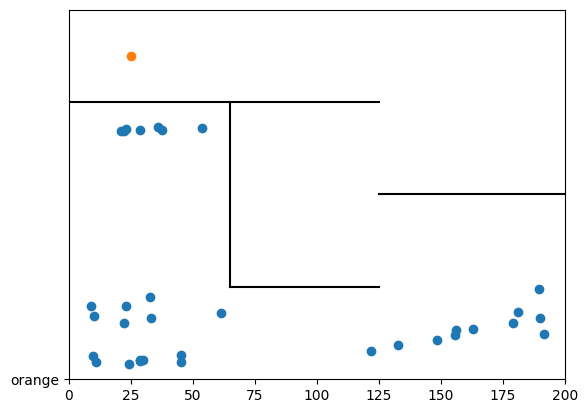

In [16]:
plt.xlim(0,200)
plt.ylim(0,200)
plt.plot(x, y, 'o')
plt.plot(x1,y1, 'black')
plt.plot(x2,y2, 'black')
plt.plot(x3,y3, 'black')
plt.plot(x4,y4, 'black')
plt.plot(x5,y5, 'o', 'orange')

### Test all networks in the archive

Let's quickly test all of the networks that have been saved in the archive. Execute the next cell and then scroll back up to the world view to see them in action. The testing code will return two pieces of information: how far the robot's end point was from the start location and how close the robot's end point was to the beacon location.

Remember that the robot can get quite close to the beacon, while still be stuck in the maze. So the distance from the start may also be an important metric to consider.

In [17]:
summary_start = []
summary_beacon = []
for i in range(len(archive)):
  dist_start, dist_beacon = ga.test_chromo(archive[i][2])
  summary_start.append((dist_start, i))
  summary_beacon.append((dist_beacon, i))

  0%|          | 0/600 [00:00<?, ?it/s]

Let's test the one that got the farthest from the start location.

In [18]:
best_start = max(summary_start)[1]
ga.test_chromo(archive[best_start][2], real_time=True)

  0%|          | 0/600 [00:00<?, ?it/s]

(166.70194060871614, 224.6632671722201)

Let's test the one that got the closest to the beacon.

In [19]:
best_beacon = min(summary_beacon)[1]
ga.test_chromo(archive[best_beacon][2], real_time=True)

  0%|          | 0/600 [00:00<?, ?it/s]

(110.26477754970294, 39.79885080851326)

## Bibliography

[1] Abandoning Objectives: Evolution Through the Search for Novelty Alone,  Joel Lehman and Kenneth O. Stanley, in Evolutionary Computation, Volume: 19, Issue: 2, June 2011. https://ieeexplore.ieee.org/document/6793380